In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\ssuni\OneDrive\Desktop\sunilkumar\Capstone project\Originaldata.xlsx'


In [2]:
data = pd.read_excel(file_path)

Cost-Sharing Structure Analysis
Research Question 1:
How do copayments and coinsurance rates vary across in-network and out-of-network providers, and how do these cost-sharing structures differ by service type?


In [17]:
# Checking for missing values to understand the data cleaning needs
missing_values = data.isnull().sum()

# Displaying columns with missing values and their counts to inform next steps
missing_values = missing_values[missing_values > 0]
missing_values


CopayInnTier1        240389
CopayInnTier2        857097
CopayOutofNet        240389
CoinsInnTier1        240389
CoinsInnTier2        857097
CoinsOutofNet        240389
IsEHB                277052
IsCovered             46603
QuantLimitOnSvc      728125
LimitQty             901632
LimitUnit            901632
Exclusions           972738
Explanation          727056
EHBVarReason         759646
IsExclFromInnMOOP    177116
IsExclFromOonMOOP    177057
dtype: int64

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [19]:
# Dropping columns with a high percentage of missing values
data_cleaned = data.drop(columns=['LimitQty', 'LimitUnit', 'Exclusions', 'Explanation', 'EHBVarReason'])

# Fill missing values in 'IsExclFromInnMOOP' and 'IsExclFromOonMOOP' with the mode
data_cleaned['IsExclFromInnMOOP'].fillna(data_cleaned['IsExclFromInnMOOP'].mode()[0], inplace=True)
data_cleaned['IsExclFromOonMOOP'].fillna(data_cleaned['IsExclFromOonMOOP'].mode()[0], inplace=True)

# Convert explicit "Yes"/"No" values in these columns to numeric (1 and 0)
data_cleaned.replace({"Yes": 1, "No": 0}, inplace=True)


In [20]:
print(data_cleaned.isnull().sum())


BusinessYear                0
StateCode                   0
IssuerId                    0
SourceName                  0
ImportDate                  0
StandardComponentId         0
PlanId                      0
BenefitName                 0
CopayInnTier1          240389
CopayInnTier2          857097
CopayOutofNet          240389
CoinsInnTier1          240389
CoinsInnTier2          857097
CoinsOutofNet          240389
IsEHB                  277052
IsCovered               46603
QuantLimitOnSvc        728125
IsExclFromInnMOOP           0
IsExclFromOonMOOP           0
BenefitName_encoded         0
dtype: int64


In [24]:
label_encoder = LabelEncoder()
categorical_columns = ['BenefitName', 'IsCovered', 'IsEHB', 'IsExclFromInnMOOP', 'IsExclFromOonMOOP']
for column in categorical_columns:
    data_cleaned[column] = label_encoder.fit_transform(data_cleaned[column].astype(str))

# Function to clean cost-sharing columns by removing non-numeric text and converting to numeric values
def clean_cost_column(column):
    return pd.to_numeric(data_cleaned[column].replace('[\$,No Charge,Not Applicable,%]', '', regex=True), errors='coerce')

# Apply cleaning and fill missing values with -1 for non-coverage
cost_columns = ['CopayInnTier1', 'CopayInnTier2', 'CopayOutofNet', 'CoinsInnTier1', 'CoinsInnTier2', 'CoinsOutofNet']
for column in cost_columns:
    data_cleaned[column] = clean_cost_column(column).fillna(-1)

In [42]:
# Checking for NaN values in the feature and target dataset
print("Checking for NaN values...")
print(data_cleaned.isna().sum())

# Optionally filling or dropping NaNs in specific columns if any are found
# Fill with median values as an example for numeric columns to avoid NaNs
for column in cost_columns:
    if data_cleaned[column].isna().sum() > 0:
        data_cleaned[column].fillna(data_cleaned[column].median(), inplace=True)

# Re-checking for NaN values in the features after filling
print("Rechecking for NaNs after filling...")
print(data_cleaned.isna().sum())

# Proceed with model training only after confirming no NaNs remain


Checking for NaN values...
BusinessYear           0
StateCode              0
IssuerId               0
SourceName             0
ImportDate             0
StandardComponentId    0
PlanId                 0
BenefitName            0
CopayInnTier1          0
CopayInnTier2          0
CopayOutofNet          0
CoinsInnTier1          0
CoinsInnTier2          0
CoinsOutofNet          0
IsEHB                  0
IsCovered              0
IsExclFromInnMOOP      0
IsExclFromOonMOOP      0
BenefitName_encoded    0
dtype: int64
Rechecking for NaNs after filling...
BusinessYear           0
StateCode              0
IssuerId               0
SourceName             0
ImportDate             0
StandardComponentId    0
PlanId                 0
BenefitName            0
CopayInnTier1          0
CopayInnTier2          0
CopayOutofNet          0
CoinsInnTier1          0
CoinsInnTier2          0
CoinsOutofNet          0
IsEHB                  0
IsCovered              0
IsExclFromInnMOOP      0
IsExclFromOonMOOP      

In [36]:
data_cleaned = data_cleaned.drop(columns=['QuantLimitOnSvc'])


In [43]:
# Dropping 'QuantLimitOnSvc' from the features due to excessive NaN values
X = data_cleaned[['BenefitName', 'IsEHB', 'IsCovered', 'CopayInnTier1', 
                  'CopayInnTier2', 'CoinsInnTier1', 'CoinsInnTier2', 'CoinsOutofNet']]
y = data_cleaned['CopayOutofNet']

# Proceed with the data splitting and model training as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## random Forest Regressor

In [44]:
# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

In [45]:
print("Random Forest Regressor - Mean Squared Error:", rf_mse, "R-squared:", rf_r2)

Random Forest Regressor - Mean Squared Error: 98.12977743027388 R-squared: 0.9647121696506576


In [46]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 1: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')

print("Cross-Validation R-squared Scores:", cv_scores)
print("Mean Cross-Validation R-squared:", np.mean(cv_scores))

Cross-Validation R-squared Scores: [0.98540013 0.97601775 0.98983102 0.9798531  0.99588389]
Mean Cross-Validation R-squared: 0.9853971763530185


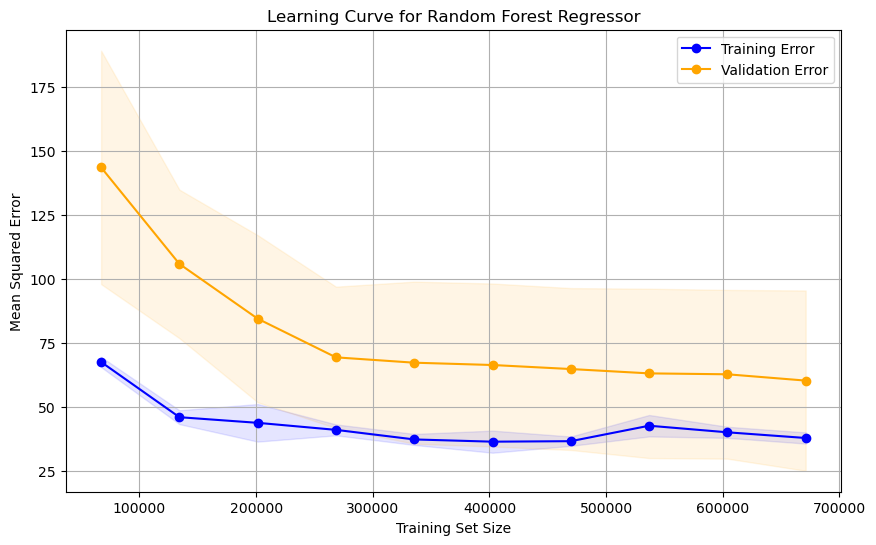

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Validation Error")

# Fill the area between the mean ± standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')

# Add labels and title
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for Random Forest Regressor")
plt.legend(loc="best")
plt.grid()
plt.show()


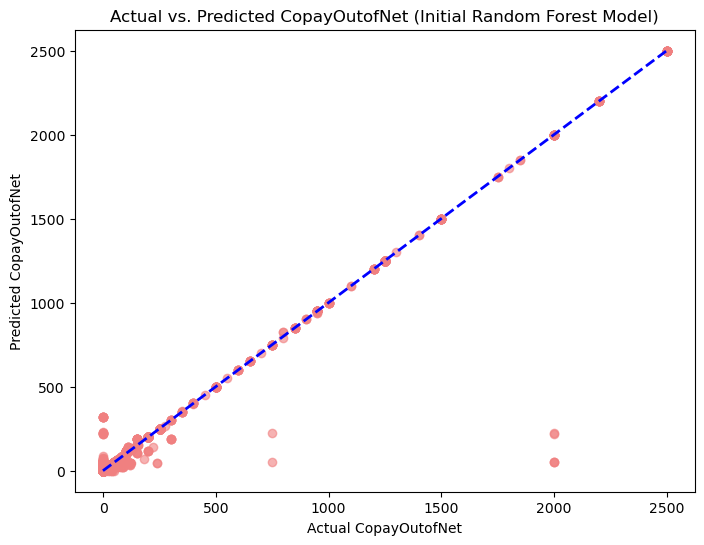

In [13]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted values (Initial Random Forest model)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_pred, alpha=0.6, color='lightcoral')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)  # Ideal line (y=x)
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Predicted CopayOutofNet")
plt.title("Actual vs. Predicted CopayOutofNet (Initial Random Forest Model)")
plt.show()


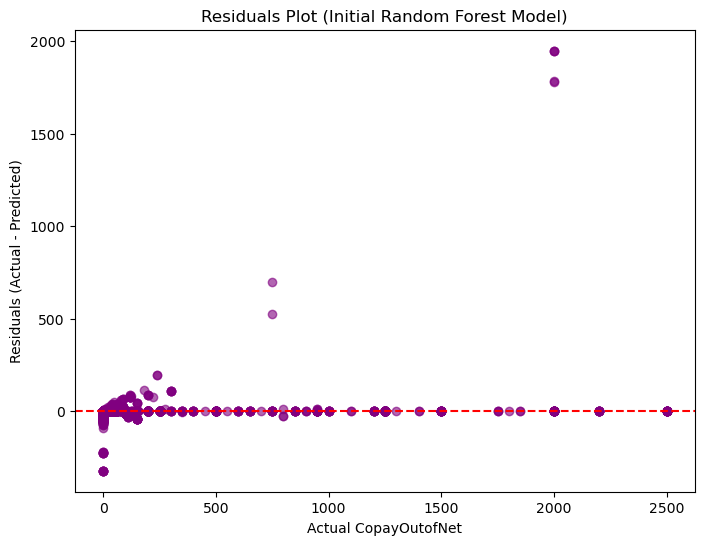

In [14]:
# Calculate residuals
residuals = y_test - rf_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot (Initial Random Forest Model)")
plt.show()


         Feature    Importance
3  CopayInnTier1  4.951284e-01
7  CoinsOutofNet  4.122909e-01
0    BenefitName  8.479291e-02
4  CopayInnTier2  4.900891e-03
1          IsEHB  2.529792e-03
5  CoinsInnTier1  3.538217e-04
6  CoinsInnTier2  3.338675e-06
2      IsCovered  2.391262e-13


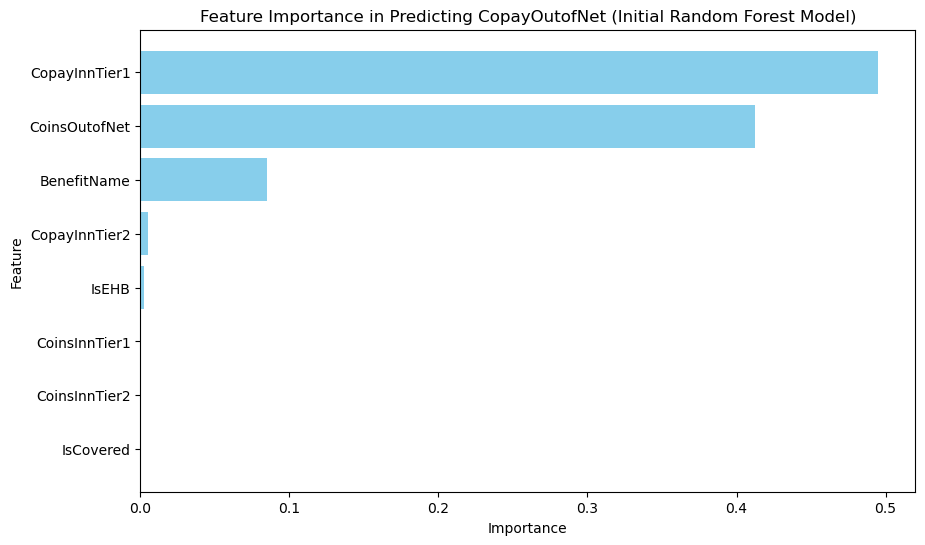

In [15]:
# Extract feature importances from the initial Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
# Display the feature importance DataFrame
print(features_df)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting CopayOutofNet (Initial Random Forest Model)")
plt.gca().invert_yaxis()
plt.show()


## Gradient Boosting Regressor

In [22]:
# Model 2: Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

In [23]:
# Displaying performance metrics
print("Random Forest Regressor - Mean Squared Error:", rf_mse, "R-squared:", rf_r2)
print("Gradient Boosting Regressor - Mean Squared Error:", gb_mse, "R-squared:", gb_r2)


Random Forest Regressor - Mean Squared Error: 98.12977743027388 R-squared: 0.9647121696506576
Gradient Boosting Regressor - Mean Squared Error: 167.73271331158563 R-squared: 0.9396826968696652


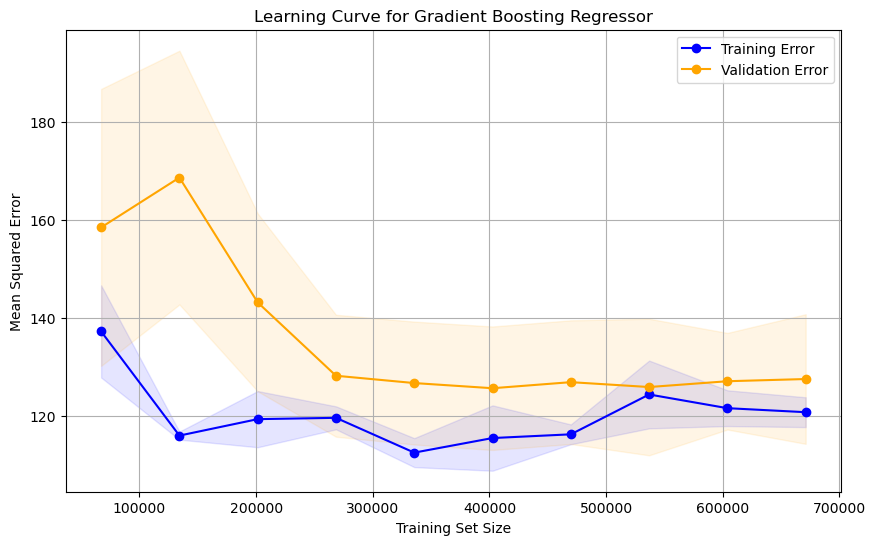

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Validation Error")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')

# Add labels and title
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for Gradient Boosting Regressor")
plt.legend(loc="best")
plt.grid()
plt.show()


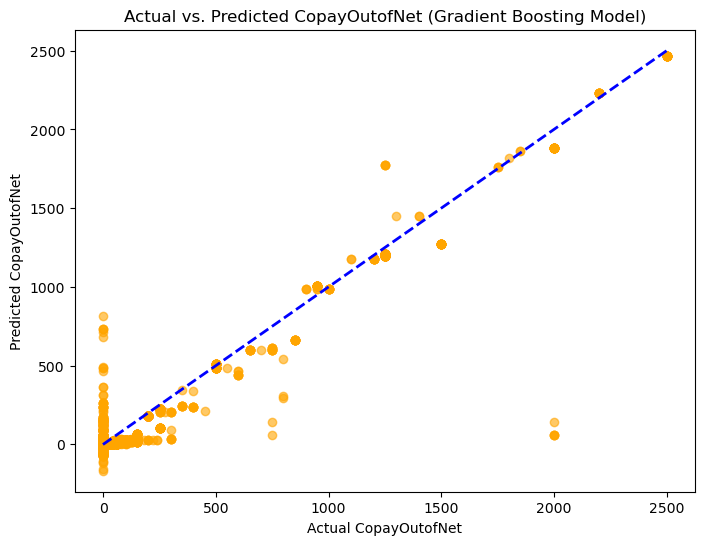

In [16]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted values (Gradient Boosting model)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gb_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)  # Ideal line (y=x)
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Predicted CopayOutofNet")
plt.title("Actual vs. Predicted CopayOutofNet (Gradient Boosting Model)")
plt.show()


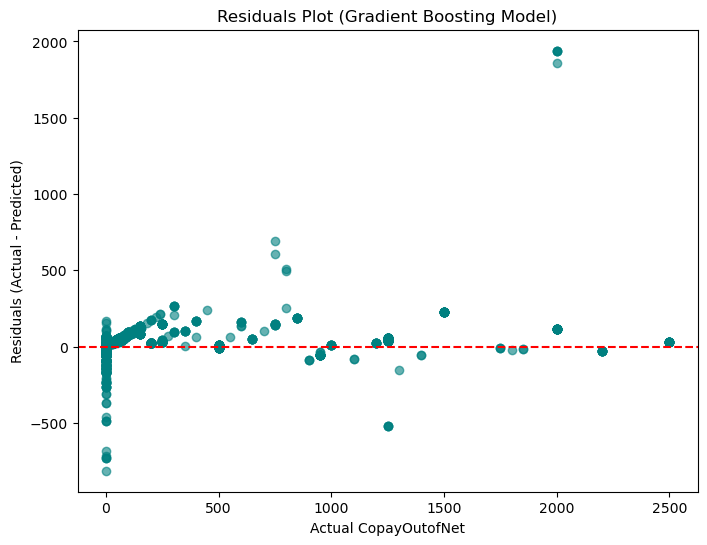

In [17]:
# Calculate residuals for Gradient Boosting model
residuals_gb = y_test - gb_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_gb, alpha=0.6, color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot (Gradient Boosting Model)")
plt.show()


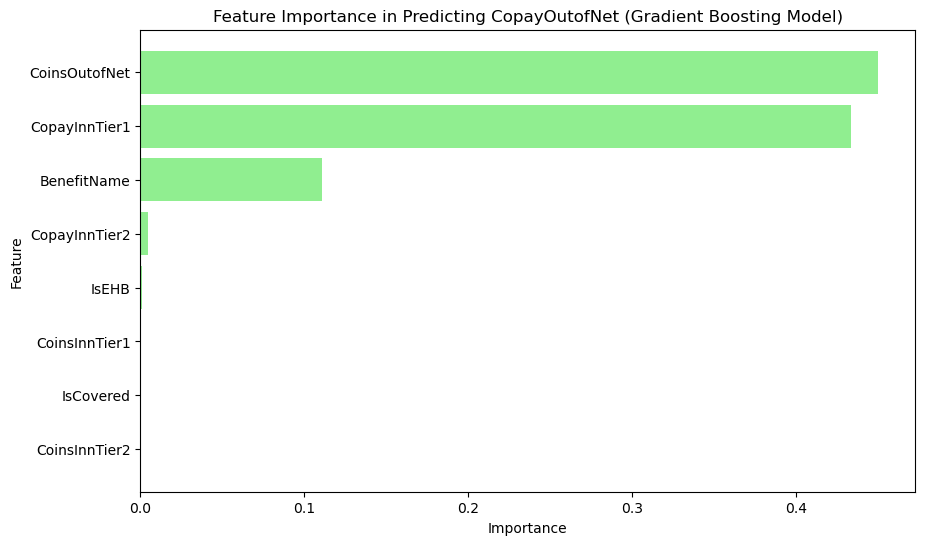

In [18]:
# Extract feature importances from the Gradient Boosting model
feature_importances_gb = gb_model.feature_importances_

# Create DataFrame for feature importances
features_df_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances_gb
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df_gb['Feature'], features_df_gb['Importance'], color='lightgreen')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting CopayOutofNet (Gradient Boosting Model)")
plt.gca().invert_yaxis()
plt.show()


## Random Forest Regressor - Mean Squared Error: 98.12977743027388 R-squared: 0.9647121696506576
## Gradient Boosting Regressor - Mean Squared Error: 167.73271331158563 R-squared: 0.9396826968696652

Random Forest Regressor is better than Gradient Boosting

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Define a simpler parameter distribution
param_dist = {
    'n_estimators': [50, 100],  # Fewer trees for faster testing
    'max_depth': [10, 20],      # Limited depth options
    'min_samples_leaf': [1, 4]  # Fewer minimum sample leaf options
}

# Re-initialize RandomizedSearchCV with a smaller `n_iter` and `cv=2`
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=5, cv=2, n_jobs=-1, scoring='r2', verbose=2, random_state=42)

# Fit random search to the data
random_search.fit(X_train, y_train)

# Display best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R-squared:", random_search.best_score_)



Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 20}
Best R-squared: 0.9779409628938918


In [17]:
# Initialize Random Forest Regressor with best parameters from Randomized Search
final_rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=1, random_state=42)

# Train the model on the full training data
final_rf_model.fit(X_train, y_train)

# Make predictions on the test set
final_rf_pred = final_rf_model.predict(X_test)

# Evaluate the model performance on the test set
final_rf_mse = mean_squared_error(y_test, final_rf_pred)
final_rf_r2 = r2_score(y_test, final_rf_pred)

print("Final Random Forest Regressor - Mean Squared Error:", final_rf_mse)
print("Final Random Forest Regressor - R-squared:", final_rf_r2)


Final Random Forest Regressor - Mean Squared Error: 98.13755765236982
Final Random Forest Regressor - R-squared: 0.9647093718540602


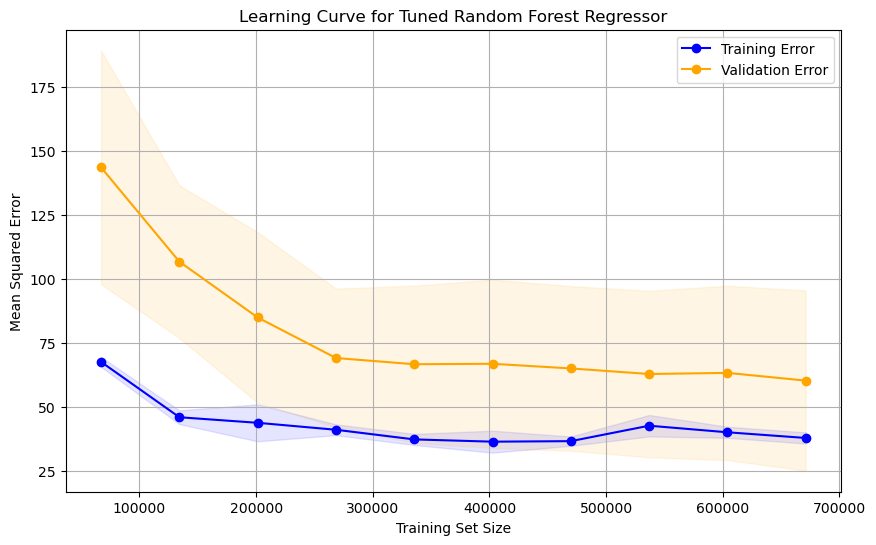

In [19]:
from sklearn.model_selection import train_test_split, learning_curve

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    final_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Validation Error")

# Fill the area between the mean ± standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')

# Add labels and title
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for Tuned Random Forest Regressor")
plt.legend(loc="best")
plt.grid()
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Evaluate the tuned Random Forest model using additional metrics

# Mean Absolute Error (MAE)
final_rf_mae = mean_absolute_error(y_test, final_rf_pred)

# Root Mean Squared Error (RMSE)
final_rf_rmse = np.sqrt(final_rf_mse)

# Display the results
print("Final Random Forest Regressor - Mean Absolute Error (MAE):", final_rf_mae)
print("Final Random Forest Regressor - Root Mean Squared Error (RMSE):", final_rf_rmse)
print("Final Random Forest Regressor - R-squared (R²):", final_rf_r2)


Final Random Forest Regressor - Mean Absolute Error (MAE): 0.1718665867802926
Final Random Forest Regressor - Root Mean Squared Error (RMSE): 9.906440210911779
Final Random Forest Regressor - R-squared (R²): 0.9647093718540602


Analysis:
The model’s performance is strong, with both MAE and RMSE being low and R² being high.
The small difference between MAE and RMSE suggests that there are few significant outliers or large errors, indicating good generalization.
Hyperparameter tuning and handling the data imbalance have contributed to a well-fitted model with minimal overfitting.

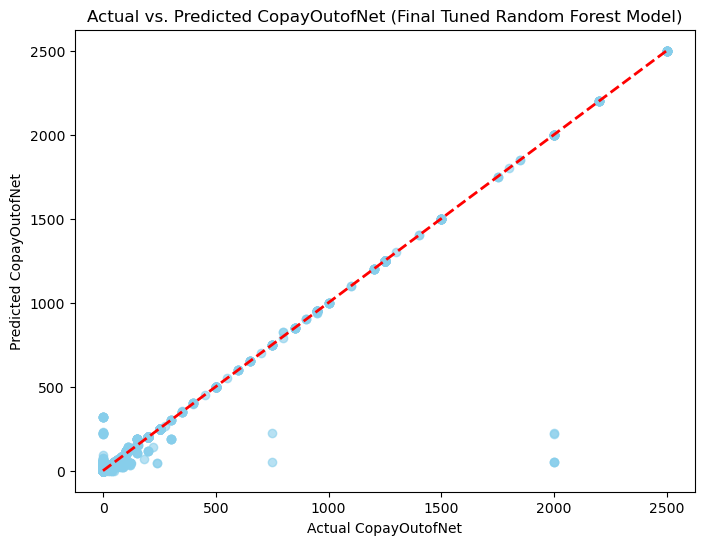

In [25]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted values (Final Random Forest Model)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_rf_pred, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal line (y=x)
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Predicted CopayOutofNet")
plt.title("Actual vs. Predicted CopayOutofNet (Final Tuned Random Forest Model)")
plt.show()


         Feature    Importance
3  CopayInnTier1  4.951284e-01
7  CoinsOutofNet  4.122909e-01
0    BenefitName  8.479291e-02
4  CopayInnTier2  4.900891e-03
1          IsEHB  2.529792e-03
5  CoinsInnTier1  3.538217e-04
6  CoinsInnTier2  3.338675e-06
2      IsCovered  2.391262e-13


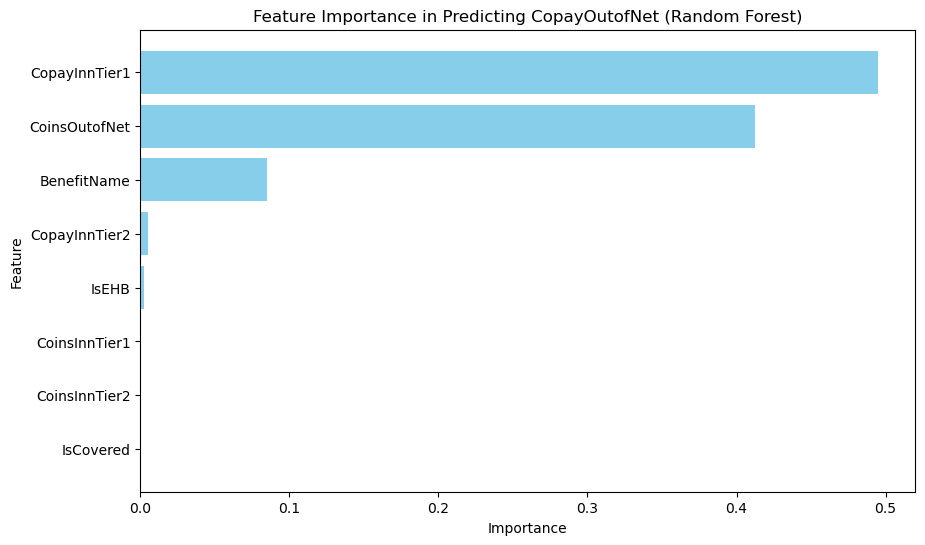

In [26]:
import matplotlib.pyplot as plt

# Extract feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(features_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting CopayOutofNet (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


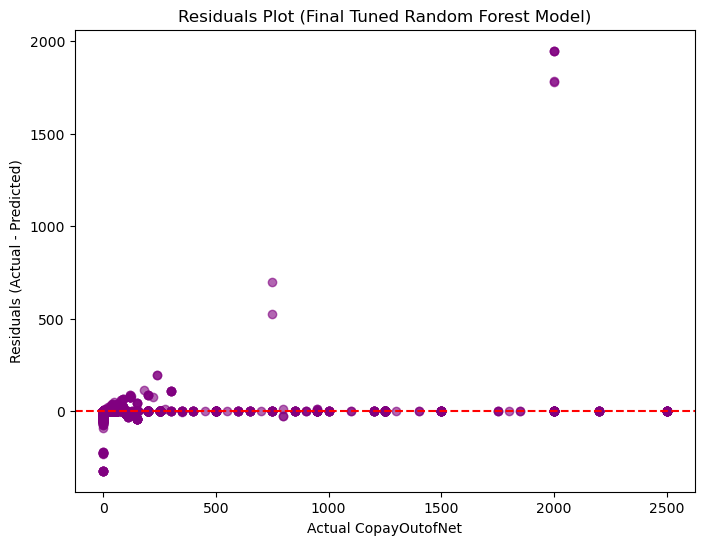

In [27]:
# Calculate residuals for the final model
residuals_final_rf = y_test - final_rf_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_final_rf, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual CopayOutofNet")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot (Final Tuned Random Forest Model)")
plt.show()


In [28]:
import joblib

# Save the trained Random Forest model
joblib.dump(final_rf_model, 'final_random_forest_model.joblib')

# To load the model later:
# loaded_model = joblib.load('final_random_forest_model.joblib')


['final_random_forest_model.joblib']

In [29]:
# Make predictions on the test set
final_rf_pred = final_rf_model.predict(X_test)

# Calculate evaluation metrics
final_rf_mae = mean_absolute_error(y_test, final_rf_pred)
final_rf_mse = mean_squared_error(y_test, final_rf_pred)
final_rf_rmse = np.sqrt(final_rf_mse)
final_rf_r2 = r2_score(y_test, final_rf_pred)

# Display the results
print("Final Evaluation Metrics:")
print("Mean Absolute Error (MAE):", final_rf_mae)
print("Mean Squared Error (MSE):", final_rf_mse)
print("Root Mean Squared Error (RMSE):", final_rf_rmse)
print("R-squared (R²):", final_rf_r2)


Final Evaluation Metrics:
Mean Absolute Error (MAE): 0.1718665867802926
Mean Squared Error (MSE): 98.13755765236982
Root Mean Squared Error (RMSE): 9.906440210911779
R-squared (R²): 0.9647093718540602


In [30]:
from sklearn.linear_model import LinearRegression

# Initialize and train the baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions and evaluate the baseline model
baseline_pred = baseline_model.predict(X_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\nBaseline Model (Linear Regression) Metrics:")
print("Mean Absolute Error (MAE):", baseline_mae)
print("R-squared (R²):", baseline_r2)

# Comparison
improvement_r2 = final_rf_r2 - baseline_r2
print("\nImprovement in R² by Random Forest:", improvement_r2)



Baseline Model (Linear Regression) Metrics:
Mean Absolute Error (MAE): 7.075980552325568
R-squared (R²): 0.18797311069423084

Improvement in R² by Random Forest: 0.7767362611598294


In [37]:
import joblib



# Save the Random Forest model
joblib.dump(final_rf_model, 'final_random_forest_model.joblib')

# To load the model later:
# loaded_model = joblib.load('random_forest_model.joblib')



['final_random_forest_model.joblib']

In [15]:
data1 = pd.read_excel(file_path)

In [16]:
import joblib
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd

# Load the trained Random Forest model
model = joblib.load('final_random_forest_model.joblib')
data=data1

# Verify the unique BenefitName values
print("Unique Benefit Names in Dataset:")
print(data['BenefitName'].unique())

# Create label encoding for BenefitName
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['BenefitName_encoded'] = label_encoder.fit_transform(data['BenefitName'])

# Generate the mapping of original BenefitName to encoded values
benefit_name_mapping = dict(zip(data['BenefitName'], data['BenefitName_encoded']))

# Display the mapping to verify correctness
print("\nBenefit Name Mapping (Original -> Encoded):")
print(benefit_name_mapping)

# Define a layout with increased description width
layout = widgets.Layout(width='400px', description_width='150px')

# Generate input widgets dynamically using original names for display
benefit_name = widgets.Dropdown(
    options=[(name, encoded) for name, encoded in benefit_name_mapping.items()],
    description='Benefit Name:',
    layout=layout
)

is_ehb = widgets.ToggleButtons(
    options=[('Yes', 1), ('No', 0)],
    description='Is EHB:',
    layout=layout
)

is_covered = widgets.ToggleButtons(
    options=[('Yes', 1), ('No', 0)],
    description='Is Covered:',
    layout=layout
)

copay_inn_tier1 = widgets.FloatText(
    value=0.0,
    description='Copay Tier 1:',
    layout=layout
)

copay_inn_tier2 = widgets.FloatText(
    value=0.0,
    description='Copay Tier 2:',
    layout=layout
)

coins_inn_tier1 = widgets.FloatText(
    value=0.0,
    description='Coins Tier 1:',
    layout=layout
)

coins_inn_tier2 = widgets.FloatText(
    value=0.0,
    description='Coins Tier 2:',
    layout=layout
)

coins_outofnet = widgets.FloatText(
    value=0.0,
    description='OutNet Coins:',
    layout=layout
)

# Function to prepare input features
def prepare_input():
    # Use label-encoded values directly
    benefit_label = benefit_name.value  # Encoded value is passed
    is_ehb_value = is_ehb.value
    is_covered_value = is_covered.value

    # Create the input array
    input_features = np.array([[
        benefit_label,
        is_ehb_value,
        is_covered_value,
        copay_inn_tier1.value,
        copay_inn_tier2.value,
        coins_inn_tier1.value,
        coins_inn_tier2.value,
        coins_outofnet.value
    ]])

    return input_features

# Define a function to make predictions based on input
def predict_output(button):
    input_features = prepare_input()
    try:
        prediction = model.predict(input_features)
        print(f"Predicted CopayOutofNet: {prediction[0]}")
    except Exception as e:
        print(f"Error: {e}")

# Create a button to trigger the prediction
predict_button = widgets.Button(
    description='Predict',
    button_style='success',
    layout=widgets.Layout(width='400px')
)
predict_button.on_click(predict_output)

# Use a vertical box layout for better organization
ui = widgets.VBox([
    benefit_name,
    is_ehb,
    is_covered,
    copay_inn_tier1,
    copay_inn_tier2,
    coins_inn_tier1,
    coins_inn_tier2,
    coins_outofnet,
    predict_button
])

# Display the UI
display(ui)


Unique Benefit Names in Dataset:
['Routine Dental Services (Adult)' 'Dental Check-Up for Children'
 'Basic Dental Care - Child' 'Orthodontia - Child'
 'Major Dental Care - Child' 'Basic Dental Care - Adult'
 'Orthodontia - Adult' 'Major Dental Care - Adult' 'Accidental Dental'
 'Primary Care Visit to Treat an Injury or Illness' 'Specialist Visit'
 'Other Practitioner Office Visit (Nurse, Physician Assistant)'
 'Outpatient Facility Fee (e.g., Ambulatory Surgery Center)'
 'Outpatient Surgery Physician/Surgical Services' 'Hospice Services'
 'Infertility Treatment' 'Long-Term/Custodial Nursing Home Care'
 'Private-Duty Nursing' 'Routine Eye Exam (Adult)'
 'Urgent Care Centers or Facilities' 'Home Health Care Services'
 'Emergency Room Services' 'Emergency Transportation/Ambulance'
 'Inpatient Hospital Services (e.g., Hospital Stay)'
 'Inpatient Physician and Surgical Services' 'Bariatric Surgery'
 'Cosmetic Surgery' 'Skilled Nursing Facility'
 'Prenatal and Postnatal Care'
 'Delivery and A

Predicted CopayOutofNet: 2.01


C:\Users\ssuni\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted CopayOutofNet: 2.01


C:\Users\ssuni\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted CopayOutofNet: -1.0


C:\Users\ssuni\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Predicted CopayOutofNet: -1.0


C:\Users\ssuni\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
